# Collaborative Insurance Sustainability and Network Structure

## Requirements

To run all the codes for the paper you need to have a working installation of:
* R
    * packages from requirements_r.txt
    
    
* Python
    * Packages from requirements.txt


* For the sparse optimization the COIN-OR Cbc MIP-solver (https://github.com/coin-or/Cbc) or any other linear programming solver for the non-sparse solutions

## Content

The random networks are generated via R-Code, set the desired parameters in the cell below:

n_nodes: Number of nodes in the network

gamma_1: First level maximum contribution ($\gamma_1$)

gamma_2: Second level maximum contribution ($\gamma_2$)

## Preliminaries

In [1]:
# globals

n_nodes = 5000
deductible = 1000

# contibutions
gamma_1 = 50
gamma_2 = 5

# working directory (as string)
wd = ''

In [2]:
import os
os.chdir(wd)

In [3]:
## Math & data
import pandas as pd
import numpy as np
import cvxpy as cp

## Viz
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

## Custom utils
from main.utils.utils_networks import prepare_lp_matrices, p2p_lin_solver, prepare_friends_of_friends_sparse, recover_sharing_amount

In [5]:
# Load simulated networks
df_network_orig = pd.read_csv('data/test_matrix_10.csv', 
                        sep=',')

# Convert such that numpy indices match
df_network_orig.id2 = df_network_orig.id2 -1 
df_network_orig.id1 = df_network_orig.id1 -1 

df_network = df_network_orig[df_network_orig.id2 < df_network_orig.id1]

In [6]:
# Set up matrices
a, AB, ab, nrow_X = prepare_lp_matrices(df_network, 
                             n_nodes, 
                             gamma_1, 
                             deductible)

# Solve Stage 1
target_stage_1 = p2p_lin_solver(a, AB, ab, nrow_X)

# Get adj_matrix^2
friends_of_friends_network = prepare_friends_of_friends_sparse(df_network_orig,
                                                               friend_level=2)

# Remove lower triangle
friends_of_friends_df_up_tria = (friends_of_friends_network[
    friends_of_friends_network.id2 < friends_of_friends_network.id1])

# Find friends of friends 
# which are also friends
doubles = friends_of_friends_df_up_tria.merge(df_network_orig, 
                                              how='inner', 
                                              left_on=['id2', 'id1'], 
                                              right_on=['id1', 'id2'])

# Remove
duplicate_removal = friends_of_friends_df_up_tria.merge(doubles,
                                                        how='left', 
                                                        left_on=['id1', 'id2'], 
                                                        right_on=['id1_x', 'id2_x'])

# Create new edgelist
friends_of_friends_network = (duplicate_removal.loc[duplicate_removal.id2_x.isna(), 
                                                    ['id1', 'id2']].reset_index(drop=True))
 
# Get residual risk
recovered_amount = recover_sharing_amount(df_network,
                                          target_stage_1.value)

max_risk_sharing = recovered_amount.copy()
max_risk_sharing['left_over'] = deductible - max_risk_sharing['node_weight']
max_risk_sharing['left_over'] = np.where(max_risk_sharing['left_over'] > 0, max_risk_sharing['left_over'], 0)
left_over = max_risk_sharing.left_over.to_numpy()

# Re-run with second stage optimization
a_2, AB_2, ab_2, nrow_X_2 = prepare_lp_matrices(friends_of_friends_network,
                                                n_nodes, 
                                                gamma_2, 
                                                deductible,
                                                left_over)

target_stage_2 = p2p_lin_solver(a_2, AB_2, ab_2, nrow_X_2)

Note: using previous results


In [7]:
%%capture
df_first_stage = df_network
df_first_stage['gamma_1'] = target_stage_1.value

total_first = (df_first_stage
               .append(df_first_stage
                       .rename(columns={
                           'id2': 'id1',
                           'id1': 'id2'})))

# Group on id
optimized_first_stage = (total_first
                         .groupby('id2')
                         .agg({'gamma_1': sum})
                         .reset_index())

df_second_stage = friends_of_friends_network
df_second_stage['gamma_2'] = target_stage_2.value

total_second = (df_second_stage
                .append(df_second_stage
                        .rename(columns={
                            'id2': 'id1',
                            'id1': 'id2'})))

optimized_second_stage = (total_second
                          .groupby('id2')
                          .agg({'gamma_2': sum})
                          .reset_index()
                          .rename(columns={'gamma_2': 'second_level'}))

optimized_second_stage['first_level'] = optimized_first_stage.gamma_1

optimized_second_stage['total_shared'] = optimized_second_stage['second_level'] + optimized_second_stage['first_level']

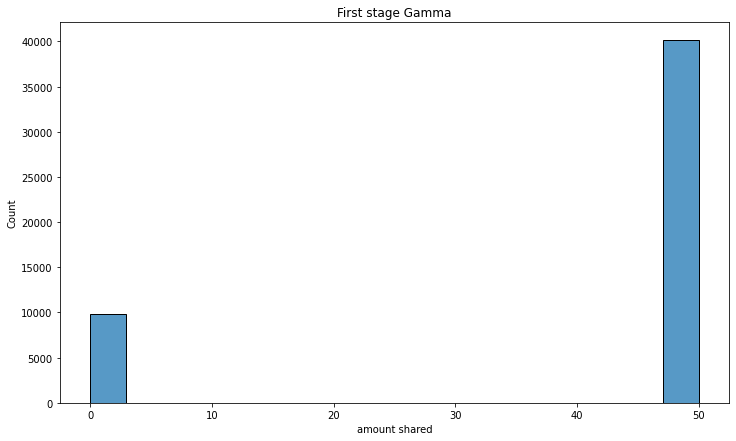

In [8]:
opt_first_ = total_first[total_first.id2 < total_first.id1]

fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(opt_first_.gamma_1)
plt.xlabel('amount shared')
plt.title('First stage Gamma');

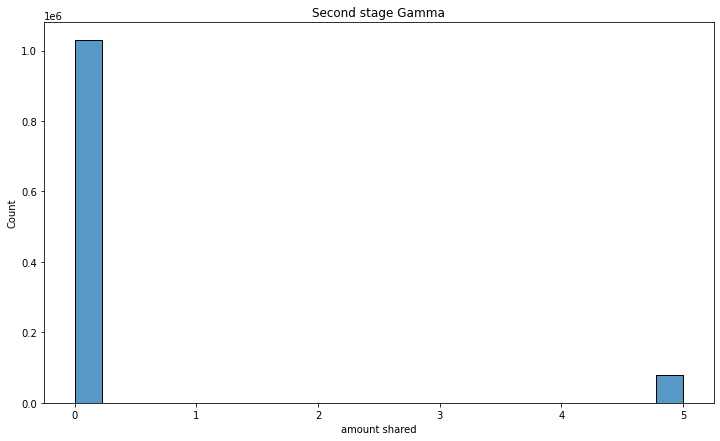

In [9]:
opt_second_ = total_second[total_second.id2 < total_second.id1]

fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(opt_second_.gamma_2)
plt.xlabel('amount shared')
plt.title('Second stage Gamma');

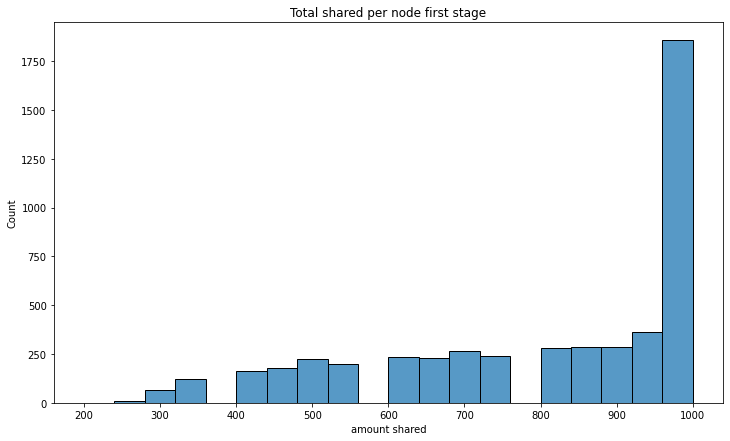

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(optimized_first_stage.gamma_1)
plt.xlabel('amount shared')
plt.title('Total shared per node first stage');

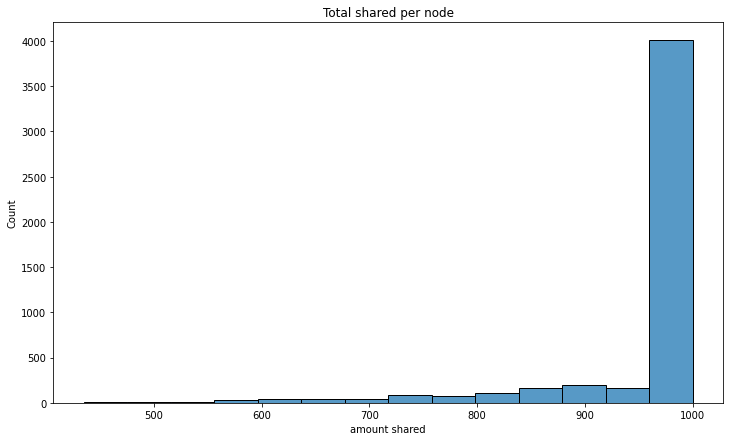

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(optimized_second_stage.total_shared)
plt.xlabel('amount shared')
plt.title('Total shared per node');

## Sparse solution 

Sparse solution according to

$$
\boldsymbol{z}^\star =\displaystyle{\underset{\boldsymbol{z}\in\mathbb{R}_+^m}{\text{argmax}}\left\lbrace\boldsymbol{1}^\top\boldsymbol{z}\right\rbrace}\\
\text{s.t. }\boldsymbol{T}^\top\boldsymbol{z}\leq s\boldsymbol{1}_m\\
~~~~z_i \leq My_i,~\forall i\\
~~~~\displaystyle{\sum_{i}y_i\leq m}
$$

In [12]:
a, AB, ab, nrow_X = prepare_lp_matrices(df_network, 
                             n_nodes, 
                             gamma_1, 
                             deductible)

In [ ]:
%%time
z = cp.Variable(nrow_X)
constraint_vector_sparsity = cp.Variable(nrow_X, boolean=True)
sparsity_level = cp.Parameter(nonneg=True)

contraints = [AB @ z <= ab,
              z >= 0,
              z <= gamma_1*constraint_vector_sparsity,
              cp.sum(constraint_vector_sparsity) <= sparsity_level
                  ]

prob = cp.Problem(cp.Maximize(a.T@z),
                 constraints=contraints)

opt_values = []
sum_values = []

exper_space = np.linspace(5000, 50000, 19)

for v in exper_space:
    print(f'working on {v}')
    sparsity_level.value = v
    prob.solve(solver=cp.CBC)
    sum_values.append(z.value.sum())
    opt_values.append(np.round(z.value))

working on 5000.0
working on 7500.0
working on 10000.0
working on 12500.0
working on 15000.0
working on 17500.0
working on 20000.0
working on 22500.0
working on 25000.0
working on 27500.0
working on 30000.0
working on 32500.0
working on 35000.0
working on 37500.0
working on 40000.0
working on 42500.0
working on 45000.0
working on 47500.0
working on 50000.0


In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(exper_space, sum_values)

plt.title('Total amount shared');